In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB,CategoricalNB,BernoulliNB
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset

In [2]:
df = pd.read_csv("pokemon_alopez247.csv")
df.head()

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,...,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,...,Green,True,0.875,Monster,Grass,False,0.71,6.9,45,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,...,Green,True,0.875,Monster,Grass,False,0.99,13.0,45,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,...,Green,True,0.875,Monster,Grass,True,2.01,100.0,45,quadruped
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,...,Red,True,0.875,Monster,Dragon,False,0.61,8.5,45,bipedal_tailed
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,...,Red,True,0.875,Monster,Dragon,False,1.09,19.0,45,bipedal_tailed


# Data Cleaning

In [3]:
idxs = df.Type_1[df.Type_2.isna()]
df.Type_2[idxs.index] = idxs

<ipython-input-3-ccd36df60563>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Type_2[idxs.index] = idxs


In [4]:
df.isna().sum()

Number                0
Name                  0
Type_1                0
Type_2                0
Total                 0
HP                    0
Attack                0
Defense               0
Sp_Atk                0
Sp_Def                0
Speed                 0
Generation            0
isLegendary           0
Color                 0
hasGender             0
Pr_Male              77
Egg_Group_1           0
Egg_Group_2         530
hasMegaEvolution      0
Height_m              0
Weight_kg             0
Catch_Rate            0
Body_Style            0
dtype: int64

In [5]:
df.drop(['Pr_Male','Egg_Group_2',"Number","Name","Total","Egg_Group_1","hasMegaEvolution"],axis=1,inplace=True)

In [6]:
df.sample(5)

,Type_1,Type_2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Height_m,Weight_kg,Catch_Rate,Body_Style
4,Fire,Fire,58,64,58,80,65,80,1,False,Red,True,1.09,19.0,45,bipedal_tailed
318,Water,Dark,70,120,40,95,40,95,3,False,Blue,True,1.80,88.8,60,with_fins
123,Ice,Psychic,65,50,35,115,95,95,1,False,Red,True,1.40,40.6,45,bipedal_tailless
337,Rock,Psychic,70,95,85,55,65,70,3,False,Red,False,1.19,154.0,45,head_only
362,Ice,Water,70,40,50,55,50,25,3,False,Blue,True,0.79,39.5,255,with_fins


Text(0.5, 0.98, 'Data Distribution For Pokemon Types')

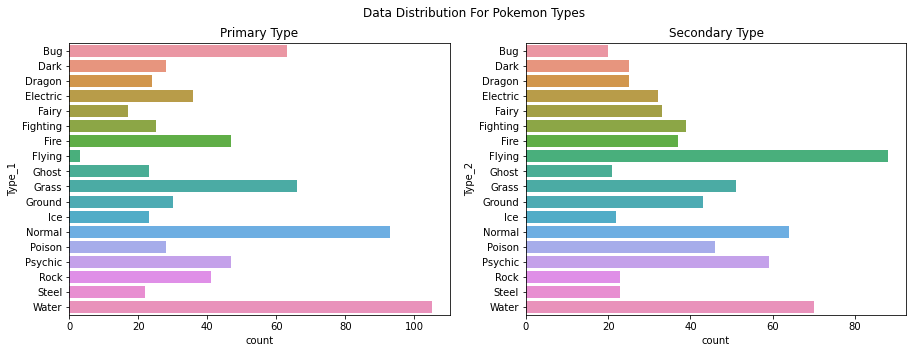

In [240]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Primary Type")
sns.countplot(y='Type_1',data=df.sort_values('Type_1'))
plt.subplot(122)
plt.title("Secondary Type")
sns.countplot(y='Type_2',data=df.sort_values('Type_2'))
plt.suptitle('Data Distribution For Pokemon Types')

Text(0.5, 0.98, 'Data Distribution For Other Important Attributes')

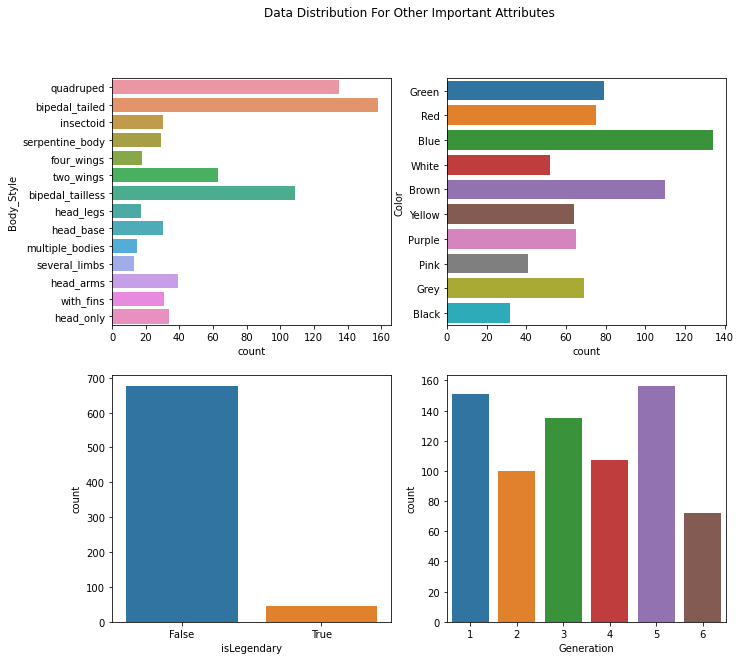

In [8]:
plt.figure(figsize=(11,10))
plt.subplot(221)
sns.countplot(y='Body_Style',data=df)
plt.subplot(222)
sns.countplot(y='Color',data=df)
plt.subplot(223)
sns.countplot(x='isLegendary',data=df)
plt.subplot(224)
sns.countplot(x='Generation',data=df)
plt.suptitle('Data Distribution For Other Important Attributes')

Text(0.5, 0.98, 'Distribution of Color for Legendary and non-Legendary Pokemon')

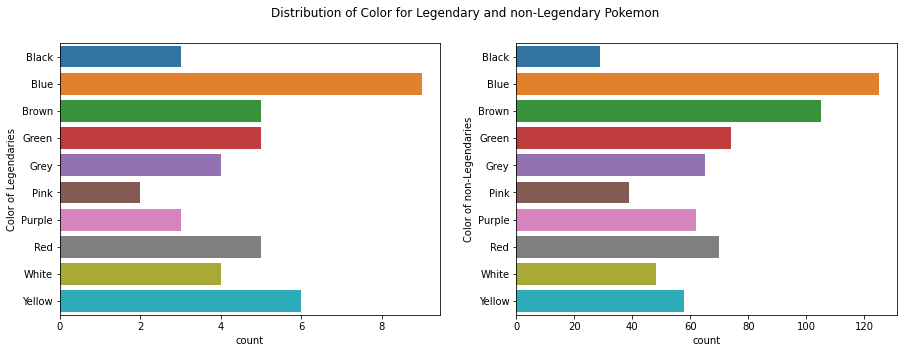

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot(y='Color',data=df[df.isLegendary].sort_values('Color'))
plt.ylabel("Color of Legendaries")
plt.subplot(122)
sns.countplot(y='Color',data=df[~df.isLegendary].sort_values('Color'))
plt.ylabel("Color of non-Legendaries")
plt.suptitle('Distribution of Color for Legendary and non-Legendary Pokemon')

In [8]:
adf = pd.concat([df.drop('Type_1',axis=1),df.drop("Type_2",axis=1)]).reset_index(drop=True)
adf.Type_1[adf.Type_1.isna()] = adf.Type_2[adf.Type_1.isna()]
adf.drop("Type_2",axis=1,inplace=True)

<ipython-input-8-75ddf74df242>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adf.Type_1[adf.Type_1.isna()] = adf.Type_2[adf.Type_1.isna()]


In [10]:
oneTypedf = df[df.Type_1 == df.Type_2].drop(["Type_2"],axis=1).reset_index(drop=True)

In [12]:
d = {x:i for i,x in enumerate(np.unique(np.concatenate((df.Type_1,df.Type_2))))}
np.bincount([d[x] for x in df.Type_2])

array([20, 25, 25, 32, 33, 39, 37, 88, 21, 51, 43, 22, 64, 46, 59, 23, 23,
       70], dtype=int64)

In [110]:
initdf = oneTypedf[["hasGender","Height_m","Weight_kg","Body_Style","Color","Generation","isLegendary","HP","Speed","Attack","Defense","Sp_Atk","Sp_Def"]]
mms = MinMaxScaler()
data_transformed = mms.fit_transform(initdf[["Height_m","Weight_kg","HP","Speed","Attack","Defense","Sp_Atk","Sp_Def"]])
initdf.Height_m,initdf.Weight_kg = data_transformed[:,0],data_transformed[:,1]
initdf.HP,initdf.Speed = data_transformed[:,2],data_transformed[:,3]
initdf.Attack,initdf.Defense = data_transformed[:,4],data_transformed[:,5]
initdf.Sp_Atk,initdf.Sp_Def = data_transformed[:,6],data_transformed[:,7]

initdf = pd.get_dummies(initdf)
initdf["Type"] = [d[x] for x in oneTypedf.Type_1]
# initdf["Type_2"] = [d[x] for x in df.Type_2]
initdf.sample(4)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,hasGender,Height_m,Weight_kg,Generation,isLegendary,HP,Speed,Attack,Defense,Sp_Atk,...,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Pink,Color_Purple,Color_Red,Color_White,Color_Yellow,Type
62,True,0.146528,0.084114,1,False,0.387755,0.586207,0.56250,0.384615,0.208333,...,0,1,0,0,0,0,0,0,0,4
253,False,0.021528,0.003158,4,False,0.285714,0.517241,0.46875,0.384615,0.486111,...,1,0,0,0,0,0,0,0,0,2
90,True,0.035417,0.009896,2,False,0.163265,0.262069,0.37500,0.302564,0.236111,...,1,0,0,0,0,0,0,0,0,2
144,True,0.013889,0.003685,3,False,0.142857,0.103448,0.25000,0.153846,0.069444,...,0,0,0,0,0,0,1,0,0,3


In [14]:
d = {x:i for i,x in enumerate(df.Type_1.unique())}
invd = {d[x]:x for x in d}
print(invd,d,sep='\n\n')

{0: 'Grass', 1: 'Fire', 2: 'Water', 3: 'Bug', 4: 'Normal', 5: 'Poison', 6: 'Electric', 7: 'Ground', 8: 'Fairy', 9: 'Fighting', 10: 'Psychic', 11: 'Rock', 12: 'Ghost', 13: 'Ice', 14: 'Dragon', 15: 'Dark', 16: 'Steel', 17: 'Flying'}

{'Grass': 0, 'Fire': 1, 'Water': 2, 'Bug': 3, 'Normal': 4, 'Poison': 5, 'Electric': 6, 'Ground': 7, 'Fairy': 8, 'Fighting': 9, 'Psychic': 10, 'Rock': 11, 'Ghost': 12, 'Ice': 13, 'Dragon': 14, 'Dark': 15, 'Steel': 16, 'Flying': 17}


In [15]:
dummy_df = pd.get_dummies(df[["hasGender","Height_m","Weight_kg","Body_Style","Color","Generation","isLegendary"]])
dummy_df.sample(3)

,hasGender,Height_m,Weight_kg,Generation,isLegendary,Body_Style_bipedal_tailed,Body_Style_bipedal_tailless,Body_Style_four_wings,Body_Style_head_arms,Body_Style_head_base,...,Color_Black,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Pink,Color_Purple,Color_Red,Color_White,Color_Yellow
256,True,1.91,52.0,3,False,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
421,True,0.30,6.3,4,False,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
361,True,1.50,256.5,3,False,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [160]:
np.bincount(initdf.Type)

array([17,  9, 11, 26, 15, 20, 28,  1,  9, 33, 13, 12, 60, 15, 32,  9,  4,
       57], dtype=int64)

In [231]:
idxs = []
for t in initdf.Type.unique():
    idxs.append(np.random.choice(initdf.Type[initdf.Type == t].index,15))
eqdf = initdf.iloc[np.ravel(idxs)]
eqdf

,hasGender,Height_m,Weight_kg,Generation,isLegendary,HP,Speed,Attack,Defense,Sp_Atk,...,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Pink,Color_Purple,Color_Red,Color_White,Color_Yellow,Type
338,True,0.090278,0.060954,5,False,0.306122,0.413793,0.57500,0.312821,0.659722,...,0,0,0,0,0,0,1,0,0,6
206,True,0.028472,0.006422,4,False,0.138776,0.386207,0.33125,0.200000,0.333333,...,0,1,0,0,0,0,0,0,0,6
0,True,0.035417,0.008843,1,False,0.118367,0.413793,0.29375,0.194872,0.347222,...,0,0,0,0,0,0,1,0,0,6
31,True,0.042361,0.019897,1,False,0.183673,0.379310,0.40625,0.205128,0.416667,...,0,1,0,0,0,0,0,0,0,6
87,True,0.028472,0.008211,2,False,0.118367,0.413793,0.29375,0.194872,0.347222,...,0,0,0,0,0,0,0,0,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,True,0.097222,0.066217,5,True,0.281633,0.731034,0.68750,0.333333,0.798611,...,0,0,1,0,0,0,0,0,0,7
339,True,0.097222,0.066217,5,True,0.281633,0.731034,0.68750,0.333333,0.798611,...,0,0,1,0,0,0,0,0,0,7
339,True,0.097222,0.066217,5,True,0.281633,0.731034,0.68750,0.333333,0.798611,...,0,0,1,0,0,0,0,0,0,7
339,True,0.097222,0.066217,5,True,0.281633,0.731034,0.68750,0.333333,0.798611,...,0,0,1,0,0,0,0,0,0,7


In [232]:
holdoutdf = initdf.iloc[[x for x in range(len(initdf)) if x not in np.ravel(idxs)]]
holdoutdf

,hasGender,Height_m,Weight_kg,Generation,isLegendary,HP,Speed,Attack,Defense,Sp_Atk,...,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Pink,Color_Purple,Color_Red,Color_White,Color_Yellow,Type
1,True,0.068750,0.019897,1,False,0.195918,0.517241,0.36875,0.271795,0.486111,...,0,0,0,0,0,0,1,0,0,6
2,True,0.028472,0.009369,1,False,0.138776,0.262069,0.26875,0.307692,0.277778,...,1,0,0,0,0,0,0,0,0,17
3,True,0.061806,0.023581,1,False,0.200000,0.365517,0.36250,0.384615,0.381944,...,1,0,0,0,0,0,0,0,0,17
4,True,0.104167,0.089904,1,False,0.281633,0.503448,0.48750,0.487179,0.520833,...,1,0,0,0,0,0,0,0,0,17
5,True,0.013889,0.002948,1,False,0.142857,0.275862,0.15625,0.153846,0.069444,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,True,0.013889,0.003579,6,False,0.212245,0.434483,0.26875,0.251282,0.368056,...,0,0,0,1,0,0,0,0,0,14
358,True,0.006944,0.000421,6,False,0.277551,0.124138,0.29375,0.282051,0.368056,...,0,0,0,0,1,0,0,0,0,4
359,True,0.047917,0.016212,6,False,0.371429,0.165517,0.41875,0.343590,0.618056,...,0,0,0,0,1,0,0,0,0,4
362,True,0.028472,0.008632,6,False,0.163265,0.268966,0.30000,0.292308,0.333333,...,1,0,0,0,0,0,0,0,0,17


In [79]:
np.bincount(y_train)

array([22, 25, 25, 22, 19, 21, 21, 21, 23, 24, 23, 24, 23, 22, 24, 22, 20,
       24], dtype=int64)

In [ ]:
#Augment data with normal distributions around each thing

<ipython-input-248-69e5a420c548>:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = nn.CrossEntropyLoss()(output,torch.tensor(y,dtype=torch.long).to(CUDA_DEVICE))
<ipython-input-248-69e5a420c548>:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valloss = nn.CrossEntropyLoss()(outs,torch.tensor(y,dtype=torch.long).to(CUDA_DEVICE)).item()
<ipython-input-248-69e5a420c548>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("loss:",nn.CrossEntropyLoss()(outs,torch.tensor(y,dtype=torch.long).to(CUDA_DEVICE)).item(),"Score:",np.mean(

Epoch: 0
loss: 2.876805305480957 Score: 0.12962962962962962
Epoch: 25
loss: 2.406848192214966 Score: 0.6111111111111112
Epoch: 50
loss: 2.3327059745788574 Score: 0.6851851851851852
Epoch: 75
loss: 2.2739717960357666 Score: 0.7222222222222222


<ipython-input-248-69e5a420c548>:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outs = model(torch.tensor(x.to(CUDA_DEVICE).float()))


Finished
Epoch: 70 loss: 2.2645180225372314 Score: 0.43137254901960786


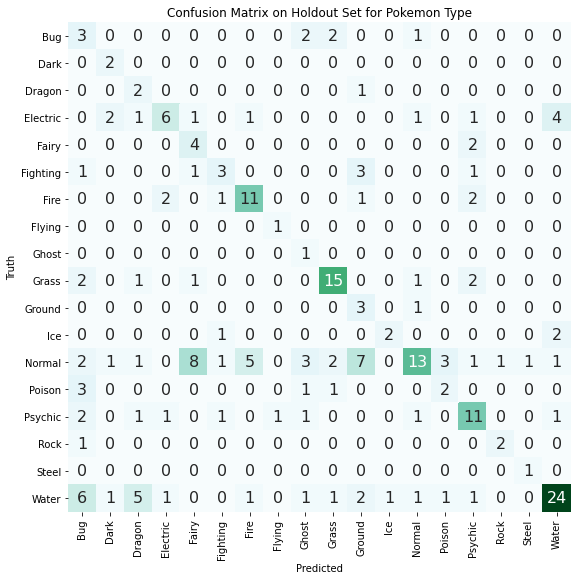

In [248]:
class dSet(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __getitem__(self,i):
        return np.array(self.x.iloc[i],dtype=np.float),np.array(self.y.iloc[i],dtype=np.long)
    def __len__(self):
        return len(self.y)
class myNet(nn.Module):
    def __init__(self):
        super(myNet,self).__init__()
#         self.dnn = nn.Sequential(*[nn.Linear(34,180),nn.BatchNorm1d(180),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(180,150),nn.BatchNorm1d(150),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(150,120),nn.BatchNorm1d(120),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(120,75),nn.BatchNorm1d(75),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(75,23),nn.BatchNorm1d(23),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(23,18),nn.Softmax(1)])
#         self.dnn = nn.Sequential(*[nn.Linear(34,26),nn.BatchNorm1d(26),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(26,23),nn.BatchNorm1d(23),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(23,20),nn.BatchNorm1d(20),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(20,18),nn.Softmax(1)])
        self.dnn = nn.Sequential(*[nn.Linear(34,26),nn.LayerNorm(26),nn.Softplus(),
#                               nn.Linear(26,15),nn.LayerNorm(15),nn.Softplus(),
#                               nn.Linear(26,8),nn.LayerNorm(8),nn.Softplus(),
                              nn.Linear(26,18),nn.Softmax(1)])
#         self.dnn = nn.Sequential(*[nn.Linear(34,200),nn.BatchNorm1d(200),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(200,130),nn.BatchNorm1d(130),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(130,80),nn.BatchNorm1d(80),nn.Softplus(),nn.Dropout(0.25),
#                               nn.Linear(80,29),nn.ReLU()])
#         self.classify = nn.Sequential(*[nn.Linear(29,18),nn.Softmax(1)])
    def forward(self,x):
        return self.dnn(x)
        b=torch.zeros_like(x)
        for _ in range(3):
            b= self.dnn(x+b)
        return self.classify(b)
    
X_train,X_val,y_train,y_val = train_test_split(eqdf.drop(['Type'],axis=1),eqdf.Type,test_size = 0.2)
X_test,y_test = holdoutdf.drop("Type",axis=1),holdoutdf.Type
EPOCHS = 501
patience = 15
bestloss = np.inf
bestepoch = 0
CUDA_DEVICE = 'cpu'
model = myNet().to(CUDA_DEVICE)
bestmodel = model.state_dict()
trainloader = DataLoader(dSet(X_train,y_train),batch_size=8,shuffle=True,drop_last=True)
valloader = DataLoader(dSet(X_val,y_val),batch_size=len(y_test))
testloader = DataLoader(dSet(X_test,y_test),batch_size=len(holdoutdf.Type))
counter = 0
optimizer = torch.optim.RMSprop(model.parameters(),lr=0.0015)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,EPOCHS)
for e in range(EPOCHS):
    model.train()
    for idx,(x,y) in enumerate(trainloader):
        optimizer.zero_grad()
        output = model(x.to(CUDA_DEVICE).float())
        loss = nn.CrossEntropyLoss()(output,torch.tensor(y,dtype=torch.long).to(CUDA_DEVICE))
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for x,y in valloader:
            outs = model(x.to(CUDA_DEVICE).float())
            valloss = nn.CrossEntropyLoss()(outs,torch.tensor(y,dtype=torch.long).to(CUDA_DEVICE)).item()
    scheduler.step(valloss)
    if bestloss > valloss:
        counter = 0
        bestloss = valloss
        bestmodel = model.state_dict()
        bestepoch = e
    elif counter > patience:
        model.load_state_dict(bestmodel)
        break
    else:
        counter+=1
    if e % 25 == 0:
        print("Epoch:",e)
        with torch.no_grad():
            print("loss:",nn.CrossEntropyLoss()(outs,torch.tensor(y,dtype=torch.long).to(CUDA_DEVICE)).item(),"Score:",np.mean((y == torch.max(outs,1)[1].cpu()).numpy()))

model.eval()
with torch.no_grad():
    for x,y in testloader:
        outs = model(torch.tensor(x.to(CUDA_DEVICE).float()))
        print("Finished\nEpoch:",bestepoch,"loss:",bestloss,"Score:",np.mean((y == torch.max(outs,1)[1].cpu()).numpy()))
        y = np.concatenate(([x for x in range(18)],y.numpy()),axis=None)
        outs = np.concatenate(([x for x in range(18)],torch.max(outs,1)[1].numpy()),axis=None)
        cm = confusion_matrix(y,outs)
plt.figure(figsize=(9,9))
sns.heatmap(cm,cbar=None,cmap='BuGn', annot=True, annot_kws={"size": 16},xticklabels=d.keys(),yticklabels=d.keys())
plt.title("Confusion Matrix on Holdout Set for Pokemon Type")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for x,y in testloader:
        outs = torch.max(model(torch.tensor(x.float())),1)[1]
        print("Score:",np.mean((y == outs).numpy()))

In [16]:
model = xgboost.XGBClassifier(n_estimators=100,n_jobs=3)
rfe = RFE(model,n_features_to_select = 19)
rfe.fit(np.concatenate((X_train,X_train)),pd.concat([y_train.Type_2,y_train.Type_1]))
X_train.columns[rfe.ranking_==1]

Index(['hasGender', 'Body_Style_bipedal_tailed', 'Body_Style_bipedal_tailless',
       'Body_Style_four_wings', 'Body_Style_insectoid', 'Body_Style_quadruped',
       'Body_Style_serpentine_body', 'Body_Style_several_limbs',
       'Body_Style_two_wings', 'Body_Style_with_fins', 'Color_Black',
       'Color_Blue', 'Color_Brown', 'Color_Green', 'Color_Grey', 'Color_Pink',
       'Color_Purple', 'Color_Red', 'Color_Yellow'],
      dtype='object')

In [ ]:
def predict(preds,y):
    preds = [x.split(' ') for x in preds]
    vals = 0
    for i,(x1,x2) in enumerate(preds):
        if x1 in y.Type_1.iloc[i] or x2 in y.Type_2.iloc[i]:
            vals+=1

    return vals/len(preds)

In [ ]:
def predict(preds,y):
    preds = [x.split(' ') for x in preds]
    vals = 0
    for i,(x1,x2) in enumerate(preds):
        if x1 in y.Type_1.iloc[i] or x2 in y.Type_2.iloc[i]:
            vals+=1

    return vals/len(preds)
#no of features
nof_list=np.arange(3,25)      
high_score=0
#Variable to store the optimum features
nof=0
score_list =[]
for n in range(len(nof_list)):
    X_train,X_test,y_train,y_test = train_test_split(initdf,df[["Type_1","Type_2"]],test_size = 0.1,random_state=30000)
    model = SVC(C=5,kernel='linear')
    rfe = RFE(model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,[x1 +' ' + x2 for x1,x2 in y_train.values])
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,[x1 +' ' + x2 for x1,x2 in y_train.values])
    score = predict(model.predict(X_test_rfe),y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

model = SVC(C=10,kernel='linear')
rfe = RFE(model,n_features_to_select = nof)
rfe.fit(X_train,[x1 +' ' + x2 for x1,x2 in y_train.values])
X_train.columns[rfe.ranking_==1]

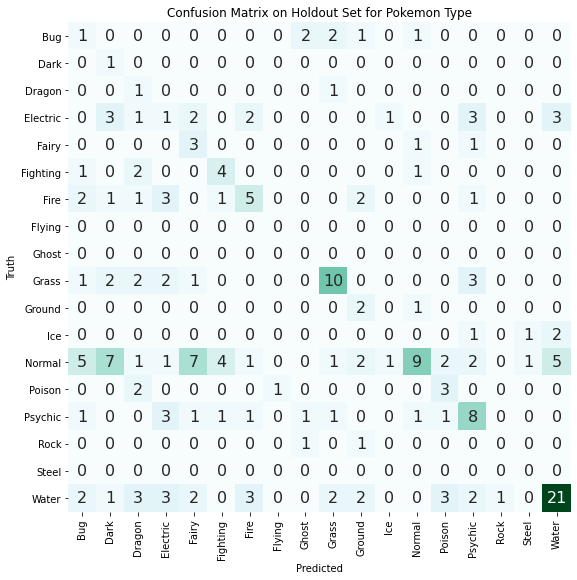

0.3382352941176471


In [271]:
# X_train,X_test,y_train,y_test = train_test_split(initdf,df[["Type_1","Type_2"]],test_size = 0.15)
model = xgboost.XGBClassifier(n_estimators=1000,n_jobs=-1)
model.fit(X_train,y_train)#[x1 +' '+ x2 for x1,x2 in y_train.values])
# x,y = dummy_df.drop(["Type_1","Type_2"],axis=1),dummy_df[["Type_1","Type_2"]]
preds = model.predict(X_test)
# preds# = [x for x in map(invy.get,preds)]
cm = confusion_matrix(y_test,preds)
plt.figure(figsize=(9,9))
sns.heatmap(cm,cbar=None,cmap='BuGn', annot=True, annot_kws={"size": 16},xticklabels=d.keys(),yticklabels=d.keys())
plt.title("Confusion Matrix on Holdout Set for Pokemon Type")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()
print(np.mean(y_test.values==preds))

This is the best I can do to predict Type

- Optimum number of features: 19
- Score with 19 features: 0.520548
- Index(['hasGender', 'isLegendary', 'Body_Style_four_wings',
       'Body_Style_insectoid', 'Body_Style_multiple_bodies',
       'Body_Style_quadruped', 'Body_Style_several_limbs',
       'Body_Style_two_wings', 'Body_Style_with_fins', 'Color_Black',
       'Color_Blue', 'Color_Brown', 'Color_Green', 'Color_Grey', 'Color_Pink',
       'Color_Purple', 'Color_Red', 'Color_White', 'Color_Yellow'],
      dtype='object')

In [173]:
pd.get_dummies(initdf)

,hasGender,Height_m,Weight_kg,Generation,isLegendary,HP,Speed,Attack,Defense,Sp_Atk,...,Color_Brown,Color_Green,Color_Grey,Color_Pink,Color_Purple,Color_Red,Color_White,Color_Yellow,Type_1,Type_2
0,True,0.042361,0.007159,1,False,0.173228,0.258065,0.27500,0.195556,0.381944,...,0,1,0,0,0,0,0,0,0,5
1,True,0.061806,0.013580,1,False,0.232283,0.354839,0.35625,0.257778,0.486111,...,0,1,0,0,0,0,0,0,0,5
2,True,0.132639,0.105169,1,False,0.311024,0.483871,0.48125,0.346667,0.625000,...,0,1,0,0,0,0,0,0,0,5
3,True,0.035417,0.008843,1,False,0.149606,0.387097,0.29375,0.168889,0.347222,...,0,0,0,0,0,1,0,0,1,1
4,True,0.068750,0.019897,1,False,0.224409,0.483871,0.36875,0.235556,0.486111,...,0,0,0,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,False,0.395139,0.213601,6,True,0.492126,0.606452,0.78750,0.400000,0.840278,...,0,0,0,0,0,1,0,0,15,17
717,False,0.340278,0.320981,6,True,0.421260,0.580645,0.59375,0.515556,0.493056,...,0,1,0,0,0,0,0,0,14,7
718,False,0.042361,0.009159,6,True,0.192913,0.290323,0.59375,0.644444,0.625000,...,0,0,0,1,0,0,0,0,11,8
719,False,0.028472,0.009369,6,True,0.311024,0.419355,0.65625,0.244444,0.972222,...,0,0,0,0,1,0,0,0,10,12


In [79]:
X_train,X_test,y_train,y_test = train_test_split(dummy_df.drop("isLegendary",axis=1),dummy_df.isLegendary,test_size = 0.15)


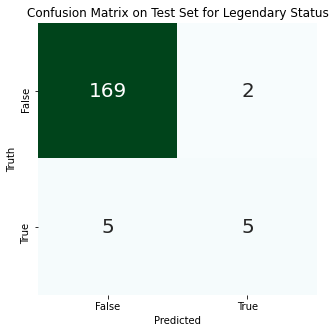

Precision: [0.97126437 0.71428571] 0.8427750410509032 
Recall: [0.98830409 0.5       ] 0.7441520467836258 
F1: [0.97971014 0.58823529] 0.7839727195225916
0.9613259668508287


In [276]:
cms = []
ytests,ypreds = [],[]
ytrains,ytpreds = [],[]
for _ in range(1):
    X_train,X_test,y_train,y_test = train_test_split(dummy_df.drop("isLegendary",axis=1),dummy_df.isLegendary,test_size = 0.25)
    model = xgboost.XGBClassifier(n_estimators=500,n_jobs=-1)
    model.fit(X_train,y_train)
    model.score(X_test,y_test) #islegendary is found by using hasGender, isYellow, and height
    pipeline_models.append(model)
    preds = model.predict(X_test)
    cms.append(confusion_matrix(y_test,preds))
    ytests.append(y_test)
    ypreds.append(preds)
    ytrains.append(y_train)
    ytpreds.append(model.predict(X_train))
cm = np.mean(np.array(cms),0,dtype=int)
plt.figure(figsize=(5,5))
sns.heatmap(cm,cbar=None,cmap='BuGn', annot=True, annot_kws={"size": 20}, fmt='g',xticklabels=["False","True"],yticklabels=["False","True"])
plt.title("Confusion Matrix on Test Set for Legendary Status")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = []
for i in range(2):
    temp = np.delete(cm, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = 2*precision*recall/(precision+recall)
print("Precision:",precision,np.mean(precision),"\nRecall:",recall,np.mean(recall),"\nF1:",f1,np.mean(f1))
print(np.sum(np.diag(cm))/np.sum(cm))

In [ ]:
xgbc = xgboost.XGBClassifier(n_estimators=20,n_jobs=2)
xgbc.fit(X_train,[x1 +' '+ x2 for x1,x2 in y_train.values])
xgbc.score(X_test,y_test)

In [ ]:
fs = RFE(xgbc)
fs.fit(X_train, y_train)
fs.score(X_test,y_test)

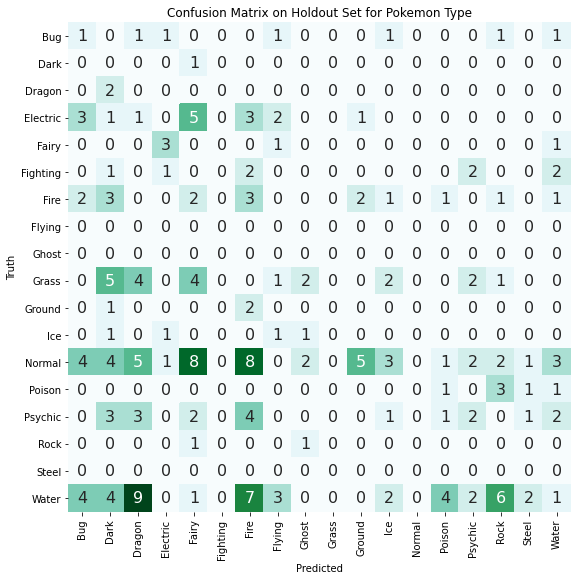

0.0392156862745098


In [262]:
kmeans = KMeans(n_clusters=18)
kmeans.fit(X_train)

preds = kmeans.predict(X_test)
cm = confusion_matrix(y_test,preds)
plt.figure(figsize=(9,9))
sns.heatmap(cm,cbar=None,cmap='BuGn', annot=True, annot_kws={"size": 16},xticklabels=d.keys(),yticklabels=d.keys())
plt.title("Confusion Matrix on Holdout Set for Pokemon Type")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()
print(np.mean(y_test.values==preds))
# kmeans.score(X_test,y_test)

In [ ]:
np.mean(kmeans.predict(X_test) == [k for k in map(d.get,y_test.Type_2)])

In [119]:
X_train,X_test,y_train,y_test = train_test_split(initdf,initdf["Type"],test_size = 0.15)
model = SVC(C=100,kernel='poly')
model.fit(X_train,y_train)
preds = model.predict(X_test)
y = np.concatenate(([x for x in range(18)],y_test),axis=None)
outs = np.concatenate(([x for x in range(18)],preds),axis=None)
cm = confusion_matrix(y,outs)
plt.figure(figsize=(9,9))
sns.heatmap(cm,cbar=None,cmap='BuGn', annot=True, annot_kws={"size": 16},xticklabels=d.keys(),yticklabels=d.keys())
plt.title("Confusion Matrix on Test Set for Pokemon Type")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()
print(np.mean(y_test.values==preds))

,Type_1,Type_2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Height_m,Weight_kg,Catch_Rate,Body_Style
0,Grass,Poison,45,49,49,65,65,45,1,False,Green,True,0.71,6.9,45,quadruped
1,Grass,Poison,60,62,63,80,80,60,1,False,Green,True,0.99,13.0,45,quadruped
2,Grass,Poison,80,82,83,100,100,80,1,False,Green,True,2.01,100.0,45,quadruped
3,Fire,Fire,39,52,43,60,50,65,1,False,Red,True,0.61,8.5,45,bipedal_tailed
4,Fire,Fire,58,64,58,80,65,80,1,False,Red,True,1.09,19.0,45,bipedal_tailed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,Dark,Flying,126,131,95,131,98,99,6,True,Red,False,5.79,203.0,45,two_wings
717,Dragon,Ground,108,100,121,81,95,95,6,True,Green,False,5.00,305.0,3,serpentine_body
718,Rock,Fairy,50,100,150,100,150,50,6,True,Pink,False,0.71,8.8,3,head_arms
719,Psychic,Ghost,80,110,60,150,130,70,6,True,Purple,False,0.51,9.0,3,head_only


In [166]:
np.multiply(cm.sum(0),precision)

array([ 7.,  5., 11.,  4.,  9.,  3.,  3.,  1.,  1.,  1.,  4.,  2.,  2.,
        1.,  2.,  2.,  2.,  1.])

In [165]:
len(cm.sum(0))

18

In [178]:
np.mean(f1)

0.8524816314289998

In [107]:
from sklearn.svm import SVR

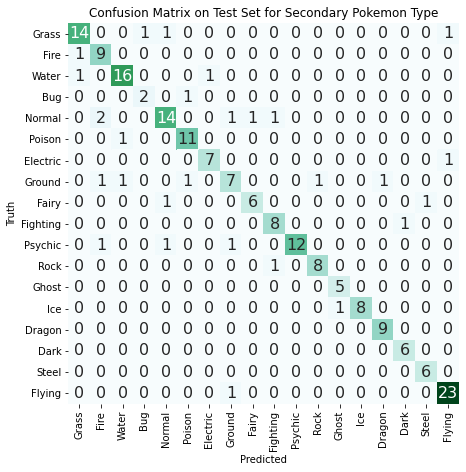

Precision
 [0.875      0.69230769 0.88888889 0.66666667 0.82352941 0.84615385
 0.875      0.7        0.85714286 0.8        1.         0.88888889
 0.83333333 1.         0.9        0.85714286 0.85714286 0.92      ] 
Avg: 0.8489554055240329 
Weighted Avg: 0.8592964824120604
Recall
 [0.82352941 0.9        0.88888889 0.66666667 0.73684211 0.91666667
 0.875      0.58333333 0.75       0.88888889 0.8        0.88888889
 1.         0.88888889 1.         1.         1.         0.95833333] 
Avg: 0.8647737262546343 
Weighted Avg: 0.869151355331871
F1
 [0.84848485 0.7826087  0.88888889 0.66666667 0.77777778 0.88
 0.875      0.63636364 0.8        0.84210526 0.88888889 0.88888889
 0.90909091 0.94117647 0.94736842 0.92307692 0.92307692 0.93877551] 
Avg: 0.8532354839921871 
Weighted Avg: 0.8608711286999831
0.8592964824120602


In [284]:
cms = []
type_models=[]
for _ in range(1):
    X_train,X_test,y_train,y_test = train_test_split(initdf.drop(["Type_1","Type_2"],axis=1),initdf["Type_1"],test_size = 0.25)
    model = SVC(C=10000)
    model.fit(X_train,y_train)
    type_models.append(model)
    
    X_train,X_test,y_train,y_test = train_test_split(initdf.drop(["Type_1","Type_2"],axis=1),initdf["Type_2"],test_size = 0.25)
    model = SVC(C=10000)
    model.fit(X_train,y_train)
    type_models.append(model)
    X_train,X_test,y_train,y_test = train_test_split(initdf.drop(["Type_1","Type_2"],axis=1),initdf["Type_2"],test_size = 0.25)

    preds = model.predict(X_test)
    y = np.concatenate(([x for x in range(18)],y_test),axis=None)
    outs = np.concatenate(([x for x in range(18)],preds),axis=None)
    cms.append(confusion_matrix(y,outs))
cm = np.mean(np.array(cms),0,dtype=int)

plt.figure(figsize=(7,7))
sns.heatmap(cm,cbar=None,cmap='BuGn', annot=True, annot_kws={"size": 16},xticklabels=d.keys(),yticklabels=d.keys())
plt.title("Confusion Matrix on Test Set for Secondary Pokemon Type")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()
TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = []
for i in range(18):
    temp = np.delete(cm, i, 0)    # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TN.append(sum(sum(temp)))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = 2*precision*recall/(precision+recall)
print("Precision\n",precision,"\nAvg:",np.mean(precision),"\nWeighted Avg:",np.sum(np.multiply(cm.sum(0)/cm.sum(),precision)))
print("Recall\n",recall,"\nAvg:",np.mean(recall),"\nWeighted Avg:",np.sum(np.multiply(cm.sum(0)/cm.sum(),recall)))
print("F1\n",f1,"\nAvg:",np.mean(f1),"\nWeighted Avg:",np.sum(np.multiply(cm.sum(0)/cm.sum(),f1)))
print(np.sum(np.diag(cm))/np.sum(cm))

In [282]:
initdf = df[["hasGender","Height_m","Weight_kg","Body_Style","Color","Generation","isLegendary","HP","Speed","Attack","Defense","Sp_Atk","Sp_Def"]]
mms = MinMaxScaler()
data_transformed = mms.fit_transform(initdf[["Height_m","Weight_kg","HP","Speed","Attack","Defense","Sp_Atk","Sp_Def"]])
initdf.Height_m,initdf.Weight_kg = data_transformed[:,0],data_transformed[:,1]
initdf.HP,initdf.Speed = data_transformed[:,2],data_transformed[:,3]
initdf.Attack,initdf.Defense = data_transformed[:,4],data_transformed[:,5]
initdf.Sp_Atk,initdf.Sp_Def = data_transformed[:,6],data_transformed[:,7]
initdf = pd.get_dummies(initdf)

statlessdf = initdf.drop(["HP","Speed",'Attack','Defense','Sp_Atk',"Sp_Def"],axis=1)
statlessdf
initdf["Type_1"] = [d[x] for x in df["Type_1"]]
initdf["Type_2"] = [d[x] for x in df["Type_2"]]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,hasGender,Height_m,Weight_kg,Generation,isLegendary,Body_Style_bipedal_tailed,Body_Style_bipedal_tailless,Body_Style_four_wings,Body_Style_head_arms,Body_Style_head_base,...,Color_Black,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Pink,Color_Purple,Color_Red,Color_White,Color_Yellow
0,True,0.042361,0.007159,1,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,True,0.061806,0.013580,1,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,True,0.132639,0.105169,1,False,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,True,0.035417,0.008843,1,False,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,True,0.068750,0.019897,1,False,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,False,0.395139,0.213601,6,True,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
717,False,0.340278,0.320981,6,True,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
718,False,0.042361,0.009159,6,True,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
719,False,0.028472,0.009369,6,True,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [275]:
for col in ["Speed"]:
    y,yhat = np.array([]),np.array([])
    for cv in range(1):
        X_train,X_test,y_train,y_test = train_test_split(statlessdf,initdf[col],test_size = 0.25)
        model = SVR()
        model.fit(X_train,y_train)
        pipeline_models.append(model)
        preds = model.predict(X_test)
        y = np.concatenate((y,y_test),axis=None)
        yhat = np.concatenate((yhat,preds),axis=None)

    print(col,(np.square(y - yhat)).mean(axis=None))


Speed 0.021845390490881068


In [273]:
for col in ['Attack']:
    y,yhat = np.array([]),np.array([])
    for cv in range(1):
        X_train,X_test,y_train,y_test = train_test_split(statlessdf,initdf[col],test_size = 0.25)
        model = xgboost.XGBRegressor(n_estimators=2000,n_jobs=2)
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        y = np.concatenate((y,y_test),axis=None)
        yhat = np.concatenate((yhat,preds),axis=None)

    print(col,(np.square(y - yhat)).mean(axis=None))


Attack 0.016736668021411185


In [262]:
for col in ["HP","Speed",'Attack','Defense','Sp_Atk',"Sp_Def"]:
    y,yhat = np.array([]),np.array([])
    for cv in range(7):
        X_train,X_test,y_train,y_test = train_test_split(statlessdf,initdf[col],test_size = 0.25)
        model = LinearRegression()
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        y = np.concatenate((y,y_test),axis=None)
        yhat = np.concatenate((yhat,preds),axis=None)

    print(col,(np.square(y - yhat)).mean(axis=None))


HP 0.008132384345519285
Speed 0.02598103663300388
Attack 0.02811103641938745
Defense 0.01328900657118687
Sp_Atk 0.029049789653253315
Sp_Def 0.0149807061487617


In [269]:
for col in ["HP",'Defense',"Sp_Def"]:
    y,yhat = np.array([]),np.array([])
    for cv in range(1):
        X_train,X_test,y_train,y_test = train_test_split(statlessdf,initdf[col],test_size = 0.25)
        model = LinearRegression(normalize=True)
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        y = np.concatenate((y,y_test),axis=None)
        yhat = np.concatenate((yhat,preds),axis=None)

    print(col,(np.square(y - yhat)).mean(axis=None))


HP 0.008738778802857951
Defense 0.012988459064556609
Sp_Def 0.01274999915164582


In [260]:
for col in ["HP","Speed",'Attack','Defense','Sp_Atk',"Sp_Def"]:
    y,yhat = np.array([]),np.array([])
    for cv in range(7):
        X_train,X_test,y_train,y_test = train_test_split(statlessdf,initdf[col],test_size = 0.25)
        model = LinearRegression(fit_intercept=False,normalize=True)
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        y = np.concatenate((y,y_test),axis=None)
        yhat = np.concatenate((yhat,preds),axis=None)

    print(col,(np.square(y - yhat)).mean(axis=None))


HP 0.007992686904659128
Speed 0.026256949821064347
Attack 0.023484187867926793
Defense 0.013506120753461415
Sp_Atk 0.03170592934099487
Sp_Def 0.014727256112743791


In [268]:
pipeline_models = []

In [280]:
print(legendaryClassifier)
print(pipeline_models)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
[LinearRegression(normalize=True), LinearRegression(normalize=True), LinearRegression(normalize=True), LinearRegression(), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_

In [286]:
pipeline = [legendaryClassifier] + pipeline_models + type_models


In [293]:
from time import time
pipedf = dummy_df.drop("isLegendary",axis=1)
temps = dict()
start = time()
for i,model in enumerate(pipeline):
    if i == 0: # Legendary
        pipedf.insert(4,"isLegendary", model.predict(pipedf))
    elif i == 1: # HP
        temps["HP"] = model.predict(pipedf)
    elif i == 2: # Defense
        temps["Defense"] = model.predict(pipedf)
    elif i == 3: # Sp Def
        temps["Sp_Def"] = model.predict(pipedf)
    elif i == 4: # Sp Atk
        temps["Sp_Atk"] = model.predict(pipedf)
    elif i == 5: # Attack
        temps["Attack"] = model.predict(pipedf)
    elif i == 6: # Speed
        temps["Speed"] = model.predict(pipedf)
        for key in temps:
            pipedf[key] = temps[key]
        temps = dict()
    elif i == 7: # Type 1
        temps["Type_1"] = model.predict(pipedf)
    elif i == 8: # Type 2
        temps["Type_2"] = model.predict(pipedf)
        for key in temps:
            pipedf[key] = temps[key]
    else:
        print("uhoh")
print(time()-start)

0.12903189659118652


In [296]:
5.5-0.13

5.37

In [291]:
a=set(['hasGender', 'Height_m', 'Weight_kg', 'Generation', 'isLegendary', 'Body_Style_bipedal_tailed', 'Body_Style_bipedal_tailless', 'Body_Style_four_wings', 'Body_Style_head_arms', 'Body_Style_head_base', 'Body_Style_head_legs', 'Body_Style_head_only', 'Body_Style_insectoid', 'Body_Style_multiple_bodies', 'Body_Style_quadruped', 'Body_Style_serpentine_body', 'Body_Style_several_limbs', 'Body_Style_two_wings', 'Body_Style_with_fins', 'Color_Black', 'Color_Blue', 'Color_Brown', 'Color_Green', 'Color_Grey', 'Color_Pink', 'Color_Purple', 'Color_Red', 'Color_White', 'Color_Yellow'])
b=set(['hasGender', 'Height_m', 'Weight_kg', 'Generation', 'Body_Style_bipedal_tailed', 'Body_Style_bipedal_tailless', 'Body_Style_four_wings', 'Body_Style_head_arms', 'Body_Style_head_base', 'Body_Style_head_legs', 'Body_Style_head_only', 'Body_Style_insectoid', 'Body_Style_multiple_bodies', 'Body_Style_quadruped', 'Body_Style_serpentine_body', 'Body_Style_several_limbs', 'Body_Style_two_wings', 'Body_Style_with_fins', 'Color_Black', 'Color_Blue', 'Color_Brown', 'Color_Green', 'Color_Grey', 'Color_Pink', 'Color_Purple', 'Color_Red', 'Color_White', 'Color_Yellow', 'isLegendary'])
a == b

True